# Supernova Host Target Selection

This notebook compares the master list of supernova host targets produced by Maayane Soumagnac and Peter Nugent and published in [DESI-doc-5430](https://desi.lbl.gov/DocDB/cgi-bin/private/ShowDocument?docid=5430) against DR8 bright and dark targets.

A simple angular separation cut between the SN host RA,Dec and the target catalogs is applied.

In [1]:
from desitarget import io
from desitarget.targetmask import desi_mask, bgs_mask

from glob import glob

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.io import ascii
from astropy.table import Table, unique
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy import units as u

import healpy as hp

mpl.rc('font', size=14)

## SN Host Master List

In [2]:
sntargets = ascii.read('master_host_clean.csv')
sntargets

sn name,index,hemisphere,ra,dec,sn_z,host_ra,host_dec,program,priority
str12,float64,str5,float64,float64,float64,float64,float64,str15,float64
09bce,1.0,north,248.825,55.6331,0.023,248.825666667,55.6344166667,IIps,2.0
09fbf,1.0,north,320.16,1.04803,0.020744,320.159333333,1.04719444444,IIps,4.0
09fbf,2.0,north,320.16,1.04803,0.020744,320.15332,1.052773,IIps,4.0
10aauv,1.0,north,107.855,49.9426,0.023,107.855190525,49.9429865759,IIps,2.0
10bau,1.0,south,139.089,17.7278,0.025958999999999996,139.090375,17.7272222222,IIps,2.0
10bgl,1.0,north,154.77,46.4565,0.03,154.771375,46.4541111111,IIps,2.0
10dvb,1.0,north,259.051,31.7933,0.022941999999999997,259.044333333,31.7923055556,IIps,2.0
10hny,1.0,north,226.105,49.4008,0.026548000000000002,226.102875,49.39875,IIps,2.0
10hny,2.0,north,226.105,49.4008,0.026548000000000002,226.1004,49.40329,IIps,2.0


### SN Host SkyCoords

Compute a `SkyCoord` array; useful for later nearest-neighbor comparisons with the target catalog.

In [3]:
sncoords = SkyCoord(ra=sntargets['host_ra'], dec=sntargets['host_dec'], unit='deg')

### Plot SN Host Coordinates

Plot the SN host positions, color-coded by SN program as identified in the master list.

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/projaxes.py:541: UserWarning: 0.0 180.0 -180.0 180.0
  warnings.warn(
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/projaxes.py:656: UserWarning: The interval between parallels is 30 deg -0.00'.
  warnings.warn(
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/projaxes.py:664: UserWarning: The interval between meridians is 30 deg -0.00'.
  warnings.warn(


Anna 8 8
IIps 55 63
RCF 1106 1169
RCF/IIps 10 1179
RCF/RCF 2 1181
SNe_Ia 7429 8610
SNe_Ia/Anna 2 8612
SNe_Ia/IIps 13 8625
SNe_Ia/RCF 2129 10754
SNe_Ia/RCF/Anna 4 10758
SNe_Ia/RCF/IIps 69 10827


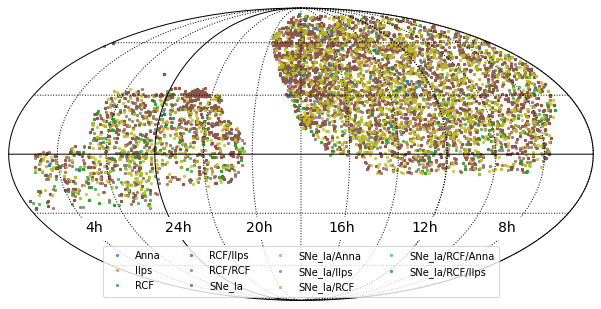

In [4]:
nside = 4
npix = hp.nside2npix(nside)
bkg = np.zeros(npix)
hp.mollview(bkg, cmap='binary', min=0, max=1, cbar=False, flip='astro', rot=270, coord='C', title=None, notext=True)
hp.graticule()

progs = np.unique(sntargets['program'])
tot = 0
for prog in progs:
    select = sntargets['program'] == prog
    tot += np.sum(select)
    print(prog, np.sum(select), tot)
    hp.projscatter(sntargets['host_ra'][select], sntargets['host_dec'][select],
                   lonlat=True, marker='o', s=5, alpha=0.7,
                   label=prog);

for _ra in [0,60,120,180,240,300,359]:
    hp.projtext(_ra, -40, '{:d}h'.format(int(np.round(_ra/15))),
                horizontalalignment='center', backgroundcolor='w', lonlat=True)

plt.legend(ncol=4, fontsize=10, loc=8);

## DR8 Target List

Load the DR8 target lists on NERSC.

In [5]:
dr8_bright = '/global/project/projectdirs/desi/target/catalogs/dr8/0.42.0/targets/main/resolve/bright'
dr8_dark = '/global/project/projectdirs/desi/target/catalogs/dr8/0.42.0/targets/main/resolve/dark'

dr8_files = sorted(glob('{}/*.fits'.format(dr8_bright))) + sorted(glob('{}/*.fits'.format(dr8_dark)))

### Compare Target RA,Dec to SN Host Location

Spin through all the DR8 target files (bright and dark time selection) without any object masks applied, and simply look for any target within a small distance (e.g., $1''$) from a SN host.

In [6]:
readcols = ['TARGETID','RA','DEC','FLUX_G','FLUX_R','FLUX_Z', 'FIBERFLUX_G', 'FIBERFLUX_R', 'FIBERFLUX_Z', 'DESI_TARGET', 'BGS_TARGET', 'MWS_TARGET']

selected_targets = None

# Spin through all DR8 files.
for dr8_file in dr8_files:
    # Construct an array of target SkyCoords.
    targets = io.read_target_files(dr8_file, columns=readcols)
    targetcoords = SkyCoord(ra=targets['RA'], dec=targets['DEC'], unit='deg')
    
    # Compute nearest-neighbor distances.
    idx, sep2d, dist3d = match_coordinates_sky(targetcoords, sncoords)
    
    # Select all close targets and append them to a table.
    select = sep2d < 3*u.arcsec
    if selected_targets is None:
        selected_targets = targets[select]
    else:
        selected_targets = np.hstack([selected_targets, targets[select]])
    
    # Just for tracking, print the number selected and the cumulative size of the stacked target list.
    print(dr8_file)
    print(np.sum(select), len(selected_targets))

/global/project/projectdirs/desi/target/catalogs/dr8/0.42.0/targets/main/resolve/bright/targets-bright-hp-0.fits
58 58
/global/project/projectdirs/desi/target/catalogs/dr8/0.42.0/targets/main/resolve/bright/targets-bright-hp-1.fits
0 58
/global/project/projectdirs/desi/target/catalogs/dr8/0.42.0/targets/main/resolve/bright/targets-bright-hp-10.fits
377 435
/global/project/projectdirs/desi/target/catalogs/dr8/0.42.0/targets/main/resolve/bright/targets-bright-hp-11.fits
357 792
/global/project/projectdirs/desi/target/catalogs/dr8/0.42.0/targets/main/resolve/bright/targets-bright-hp-12.fits
77 869
/global/project/projectdirs/desi/target/catalogs/dr8/0.42.0/targets/main/resolve/bright/targets-bright-hp-13.fits
58 927
/global/project/projectdirs/desi/target/catalogs/dr8/0.42.0/targets/main/resolve/bright/targets-bright-hp-14.fits
154 1081
/global/project/projectdirs/desi/target/catalogs/dr8/0.42.0/targets/main/resolve/bright/targets-bright-hp-15.fits
57 1138
/global/project/projectdirs/desi

### Check Unique Targets and Plot Positions

For targets within 1" of the master host catalog, pick out those with a BGS_BRIGHT flag.

In [7]:
selected_targets = unique(Table(selected_targets))

In [8]:
selected_targets

RA,DEC,FLUX_G,FLUX_R,FLUX_Z,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,TARGETID,DESI_TARGET,BGS_TARGET,MWS_TARGET
float64,float64,float32,float32,float32,float32,float32,float32,int64,int64,int64,int64
0.3107400027145378,28.858515161544602,59.842617,129.29637,212.59895,27.96397,60.419147,99.34577,35186424743464252,1152921504606846976,131074,0
0.5534030648419186,26.356648641763098,61.533913,125.34999,224.12729,9.367023,19.081451,34.117863,35186371014430366,1152921504606846976,131074,0
0.5728411919051729,27.91509294463189,45.003296,107.754036,210.18095,8.612151,20.62058,40.22172,35186408758968949,1152921504606846976,131074,0
0.6414931165408103,2.3325828328963683,56.614162,141.20287,290.84152,8.373433,20.8844,43.01648,35185812119231238,1152921504606846976,131074,0
0.6466428559922484,10.866977964485049,48.818268,95.122185,172.68155,20.162687,39.286907,71.32011,35186016205672715,1152921504606846976,131074,0
0.663959029683103,2.3357507303931233,115.75424,284.78015,535.50507,24.166313,59.454292,111.79879,35185812119231327,1152921504606846976,131074,0
0.8012377653777681,-10.834768815881368,194.45332,340.14297,507.00223,15.20028,26.588741,39.63201,35185499421278524,1152921504606846976,131074,0
0.8034943488543913,24.999883256802338,2.7954688,15.334429,37.054817,0.65736604,3.6059542,8.7135935,35186343713703988,1152921504606912513,131074,0
1.3311239869085614,12.508419385885365,24.09697,38.78432,55.6864,6.7287407,10.829977,15.549645,35186057691531651,1152921504606846976,131074,0


In [9]:
select_bgs = (selected_targets['BGS_TARGET'] & bgs_mask.mask('BGS_BRIGHT|BGS_WISE')) != 0
selected_bgs_targets = selected_targets[select_bgs]

In [10]:
selected_bgs_targets

RA,DEC,FLUX_G,FLUX_R,FLUX_Z,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,TARGETID,DESI_TARGET,BGS_TARGET,MWS_TARGET
float64,float64,float32,float32,float32,float32,float32,float32,int64,int64,int64,int64
0.3107400027145378,28.858515161544602,59.842617,129.29637,212.59895,27.96397,60.419147,99.34577,35186424743464252,1152921504606846976,131074,0
0.5534030648419186,26.356648641763098,61.533913,125.34999,224.12729,9.367023,19.081451,34.117863,35186371014430366,1152921504606846976,131074,0
0.5728411919051729,27.91509294463189,45.003296,107.754036,210.18095,8.612151,20.62058,40.22172,35186408758968949,1152921504606846976,131074,0
0.6414931165408103,2.3325828328963683,56.614162,141.20287,290.84152,8.373433,20.8844,43.01648,35185812119231238,1152921504606846976,131074,0
0.6466428559922484,10.866977964485049,48.818268,95.122185,172.68155,20.162687,39.286907,71.32011,35186016205672715,1152921504606846976,131074,0
0.663959029683103,2.3357507303931233,115.75424,284.78015,535.50507,24.166313,59.454292,111.79879,35185812119231327,1152921504606846976,131074,0
0.8012377653777681,-10.834768815881368,194.45332,340.14297,507.00223,15.20028,26.588741,39.63201,35185499421278524,1152921504606846976,131074,0
0.8034943488543913,24.999883256802338,2.7954688,15.334429,37.054817,0.65736604,3.6059542,8.7135935,35186343713703988,1152921504606912513,131074,0
1.3311239869085614,12.508419385885365,24.09697,38.78432,55.6864,6.7287407,10.829977,15.549645,35186057691531651,1152921504606846976,131074,0


<ipython-input-11-279655a508f1>:1: RuntimeWarning: divide by zero encountered in log10
  g_bgs, r_bgs, z_bgs = [22.5 - 2.5*np.log10(selected_bgs_targets['FLUX_{}'.format(_)]) for _ in 'GRZ']
<ipython-input-11-279655a508f1>:2: RuntimeWarning: divide by zero encountered in log10
  g_all, r_all, z_all = [22.5 - 2.5*np.log10(selected_targets['FLUX_{}'.format(_)]) for _ in 'GRZ']
<ipython-input-11-279655a508f1>:2: RuntimeWarning: invalid value encountered in log10
  g_all, r_all, z_all = [22.5 - 2.5*np.log10(selected_targets['FLUX_{}'.format(_)]) for _ in 'GRZ']


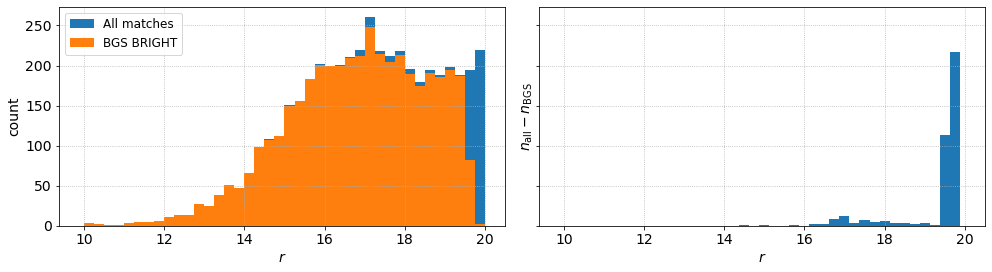

In [11]:
g_bgs, r_bgs, z_bgs = [22.5 - 2.5*np.log10(selected_bgs_targets['FLUX_{}'.format(_)]) for _ in 'GRZ']
g_all, r_all, z_all = [22.5 - 2.5*np.log10(selected_targets['FLUX_{}'.format(_)]) for _ in 'GRZ']

fig, axes = plt.subplots(1,2, figsize=(14,4), sharex=True, sharey=True, tight_layout=True)

ax = axes[0]
n_all, bins, patches = ax.hist(r_all, bins=np.linspace(10,20,41), label='All matches')
n_bgs, bins, patches = ax.hist(r_bgs, bins=bins, label='BGS BRIGHT')
ax.set(xlabel='$r$', ylabel='count')
ax.legend(fontsize=12, loc='upper left')
ax.grid(ls=':')

ax = axes[1]
ax.bar(bins[:-1], n_all-n_bgs, width=np.diff(bins))
len(n_all - n_bgs), bins[:-1], len(np.diff(bins))
ax.set(xlabel='$r$', ylabel='$n_\mathrm{all}-n_\mathrm{BGS}$')
ax.grid(ls=':');

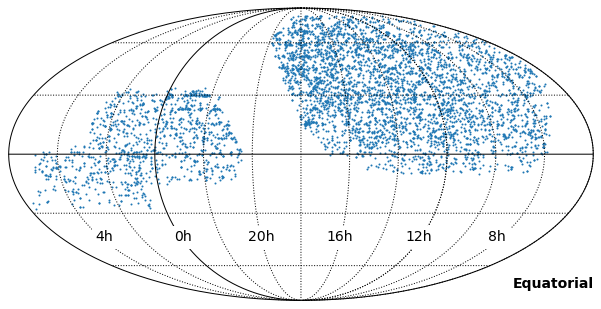

In [12]:
hp.mollview(bkg, cmap='binary', min=0, max=1, cbar=False, flip='astro', rot=270, coord='C', title='')
hp.graticule(dpar=30, dmer=30)
hp.projscatter(selected_targets['RA'], selected_targets['DEC'],
               lonlat=True, marker='o', s=1);

for _ra in np.arange(0,360,60):
    hp.projtext(_ra, -45, '{:d}h'.format(_ra//15), horizontalalignment='center', backgroundcolor='w', lonlat=True)

In [13]:
selected_bgs_targets.write('snhost_dr8_bgs_bright_target.fits', overwrite=True)

### Properties of Non-BGS Bright Targets

Look at the targets that don't have a BGS_BRIGHT flag set.

In [14]:
selected_other_targets = selected_targets[~select_bgs]
selected_other_targets

RA,DEC,FLUX_G,FLUX_R,FLUX_Z,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,TARGETID,DESI_TARGET,BGS_TARGET,MWS_TARGET
float64,float64,float32,float32,float32,float32,float32,float32,int64,int64,int64,int64
2.126348657254245,-1.5249374768258743,7.0300207,9.929488,12.449894,1.2661736,1.7883952,2.2423444,35185721547426368,1152921504606846976,65537,0
2.5415843624105525,-4.710532587490732,97.01857,194.78484,285.7138,75.54127,151.6647,222.46446,35185643113943542,2305843009213693952,0,10240
3.4083686140047607,27.5646594543528,7.4338737,12.34699,17.924726,1.5658098,2.6006682,3.7755165,35186398080273698,1152921504606846976,65537,0
3.8306840311717223,21.56633786365595,0.43832064,0.27477238,1.0024656,0.07159058,0.044878364,0.16373195,35186265884200083,131074,0,0
3.8318264139022453,21.564462656879986,0.43771008,0.73169154,1.5499425,0.14191404,0.2372285,0.5025212,35186265884200081,131074,0,0
4.665064630787487,2.1842450269352693,5.3671875,7.2343106,11.323779,4.1747875,5.6271014,8.808034,35185812186334871,131074,0,0
4.770493765799428,22.88895903322284,0.3613295,0.64624685,1.2150118,0.07306446,0.13067761,0.24568762,35186299518320930,131074,0,0
6.610278949142229,16.012426390875643,5.3021116,11.1791725,19.378489,1.7917813,3.7778597,6.5487146,35186139866335229,1152921504606846976,65537,0
8.390431566123853,21.780673899779178,1.6451912,2.4101918,4.4489536,0.16980799,0.24876733,0.4591976,35186271584258830,131074,0,0


#### Mask Bits of Matching Targets (Non-BGS Bright)

In [15]:
print('DESI_TARGET bits:')
for _nm in ['LRG', 'ELG', 'QSO', 'BGS_ANY', 'MWS_ANY']:
    _select = selected_other_targets['DESI_TARGET'] & desi_mask.mask(_nm) != 0
    n_select = np.sum(_select)
    print('- {:<20s} {:>4d}'.format(_nm, n_select)) 

print('\nBGS_TARGET bits:')
for _nm in bgs_mask.names():
    _select = selected_other_targets['BGS_TARGET'] & bgs_mask.mask(_nm) != 0
    n_select = np.sum(_select)
    print('- {:<20s} {:>4d}'.format(_nm, n_select)) 

DESI_TARGET bits:
- LRG                   121
- ELG                   406
- QSO                    26
- BGS_ANY               422
- MWS_ANY                56

BGS_TARGET bits:
- BGS_FAINT             422
- BGS_BRIGHT              0
- BGS_WISE                0
- BGS_FAINT_HIP          39
- BGS_FAINT_NORTH       168
- BGS_BRIGHT_NORTH        0
- BGS_WISE_NORTH          0
- BGS_FAINT_SOUTH       254
- BGS_BRIGHT_SOUTH        0
- BGS_WISE_SOUTH          0
